In [2]:
# Package Imports - feel free to add what you think might be useful! 
import requests
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from math import log2
from typing import List, Tuple

## Task 3: Quest for Quantum Randomness

### Part A: Truly Different

In [3]:
#Constants

QRNG_API_URL = "https://qrng.idqloud.com/api/1.0"
API_KEY = "aTo4BKRvnc49uRWDk034zaua87vGRXKk9TMLdfkI"

In [4]:
""" 
Using the QRNGaaS User Manual provided, 
write Python code to get random numbers from IDQuantique's Quantum Random Number Generators. 

The API documentation is available at: https://drive.google.com/file/d/1OkyRUP7HC4dbmi8OvoT4EuvXqRVGdsjD/view
You'll probably reuse this code for Task 4. So write it well!

If you are unfamiliar with writing HTTP requests in Python, 
https://www.w3schools.com/python/module_requests.asp

If you're really stuck, this can definitely help. Though we encourage you to read the documentation yourself! 
https://curlconverter.com/python/
"""


" \nUsing the QRNGaaS User Manual provided, \nwrite Python code to get random numbers from IDQuantique's Quantum Random Number Generators. \n\nThe API documentation is available at: https://drive.google.com/file/d/1OkyRUP7HC4dbmi8OvoT4EuvXqRVGdsjD/view\nYou'll probably reuse this code for Task 4. So write it well!\n\nIf you are unfamiliar with writing HTTP requests in Python, \nhttps://www.w3schools.com/python/module_requests.asp\n\nIf you're really stuck, this can definitely help. Though we encourage you to read the documentation yourself! \nhttps://curlconverter.com/python/\n"

### Class for using API for getting random numbers

In [5]:
class QRNGaaS:
    def __init__(self, api_key: str):
        self.base_url = QRNG_API_URL
        self.headers = {
            "X-API-KEY": api_key,
            "Content-Type": "application/json"
        }
        self.max_batch_size = 64  # Actual API limit (32 for int, 64 for short)
        self.max_double_batch = 16
    
    def get_random_ints_batched(self, quantity: int) -> List[int]:
        """Get random 32-bit integers with batching to handle API limits"""
        batches = quantity // self.max_batch_size
        remainder = quantity % self.max_batch_size
        
        results = []
        for _ in range(batches):
            results.extend(self._get_batch(self.max_batch_size))
        
        if remainder > 0:
            results.extend(self._get_batch(remainder))
            
        return results
    
    def _get_batch(self, batch_size: int) -> List[int]:
        """Get a single batch of random integers"""
        params = {"quantity": batch_size}
        try:
            response = requests.get(
                f"{self.base_url}/short",
                headers=self.headers,
                params=params,
                timeout=10  # Add timeout to prevent hanging
            )
            response.raise_for_status()
            return response.json()["data"]
        except requests.exceptions.RequestException as e:
            print(f"API request failed: {e}")
            return []  # Return empty list on failure
        
    def _get_double_batch(self, batch_size: int, min_val: float, max_val: float) -> List[float]:
        params = {"min": min_val, "max": max_val, "quantity": batch_size}
        try:
            resp = requests.get(f"{self.base_url}/double", headers=self.headers, params=params, timeout=10)
            resp.raise_for_status()
            return resp.json()["data"]
        except requests.RequestException as e:
            print(f"Double batch request failed: {e}")
            return []

    def get_random_doubles_batched(
        self,
        quantity: int,
        min_val: float = 0.0,
        max_val: float = 1.0
    ) -> List[float]:
        """
        Retrieve 'quantity' true-random doubles in [min_val, max_val), batching to respect API limits.
        """
        full_batches = quantity // self.max_double_batch
        remainder = quantity % self.max_double_batch
        result: List[float] = []
        for _ in range(full_batches):
            result.extend(self._get_double_batch(self.max_double_batch, min_val, max_val))
        if remainder:
            result.extend(self._get_double_batch(remainder, min_val, max_val))
        return result
        


In [6]:
# Initialize QRNG - REPLACE WITH YOUR ACTUAL API KEY
qrng = QRNGaaS(API_KEY)

# Analysis Parameters
SAMPLE_SIZES  = [1,5,10,50,100,250,500,1000,2500, 10000, 20000]  # Reduced max size due to API limits
BIT_LENGTH = 16  # 32-bit integers
NUM_TRIALS = 3   # Reduced trials to avoid rate limiting
REQUEST_DELAY = 0.1  # Small delay between API calls to avoid rate limiting

### Shanon Entropy Calculation Function

In [7]:
def shannon_entropy(data: List[int], bit_length: int = BIT_LENGTH) -> float:
    """
    Calculate Shannon entropy for a set of integers,
    with results normalized to the theoretical maximum
    """
    if not data:
        return 0.0
    
    # Calculate observed probabilities
    counts = Counter(data)
    probabilities = [count / len(data) for count in counts.values()]
    
    # Calculate raw entropy
    raw_entropy = -sum(p * np.log2(p) for p in probabilities if p > 0)
    
    # For integers in range [0, 2^bit_length-1], the max entropy should be bit_length
    max_possible_entropy = bit_length
    
    return min(raw_entropy, max_possible_entropy)  # Cap at theoretical maximum

### Bitrate Calculation Function

In [8]:
def calculate_bitrate(qrng: QRNGaaS, num_values: int, bits_per_value: int) -> Tuple[float, float]:
    """Calculate bitrate (bits/sec) with proper batching"""
    start_time = time.time()
    qrng.get_random_ints_batched(num_values)  # Generate the values
    elapsed = time.time() - start_time
    total_bits = num_values * bits_per_value
    return total_bits / elapsed if elapsed > 0 else 0.0, elapsed

In [9]:
"""
To get started, we provide a simple example of how to use the API to generate 10 int16 random numbers.
In particular, observe where we pass in the min and max parameters to specify the range of random numbers we want
and the quantity parameter to specify how many random numbers we want.
Here is the API KEY you will need to use: aTo4BKRvnc49uRWDk034zaua87vGRXKk9TMLdfkI
"""

!curl "https://qrng.idqloud.com/api/1.0/short?max=32767&min=-32768&quantity=10" -X GET -H "X-API-KEY: <ADD API KEY FROM ABOVE HERE>"


{"status": 403, "detail":"INVALID_API_KEY","title": "Forbidden", "type":"https://datatracker.ietf.org/doc/html/rfc7231#section-6.5.3" }


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100   136  100   136    0     0     91      0  0:00:01  0:00:01 --:--:--    91


### Getting values from API for selected sample size and calculating its entropy and bitrate value

In [14]:
"""
You can paste the other environmental entropy based TRNGs from Task 2 and compare the performance
Compare your written QRNG to the previous TRNGs. Be sure to compare them with respect to bitrate and entropy.
"""
# Entropy Analysis
print("Running entropy analysis (this may take a while due to API limits)...")
entropy_values = []
for size in SAMPLE_SIZES:
    time.sleep(REQUEST_DELAY)  
    data = qrng.get_random_ints_batched(size)
    if len(data) != size:
        print(f"Warning: Only got {len(data)}/{size} values")
    
    entropy = shannon_entropy(data, BIT_LENGTH)
    entropy_values.append(entropy)
    print(f"Sample size: {size}, Entropy: {entropy:.2f} bits")

# Bitrate Analysis
print("\nRunning bitrate analysis...")
bitrates = []
test_size = 1000  # Fixed size for bitrate comparison

for trial in range(NUM_TRIALS):
    time.sleep(REQUEST_DELAY)  
    bitrate, elapsed = calculate_bitrate(qrng, test_size, BIT_LENGTH)
    if bitrate > 0:  # Only record successful trials
        bitrates.append(bitrate)
        print(f"Trial {trial+1}: {bitrate:.2f} bits/sec (took {elapsed:.4f} sec)")
    else:
        print(f"Trial {trial+1} failed")

Running entropy analysis (this may take a while due to API limits)...
Sample size: 1, Entropy: -0.00 bits
Sample size: 5, Entropy: 2.32 bits
Sample size: 10, Entropy: 3.32 bits
Sample size: 50, Entropy: 5.64 bits
Sample size: 100, Entropy: 6.64 bits
Sample size: 250, Entropy: 7.97 bits
Sample size: 500, Entropy: 8.95 bits
Sample size: 1000, Entropy: 9.96 bits
Sample size: 2500, Entropy: 11.25 bits
Sample size: 10000, Entropy: 13.14 bits
Sample size: 20000, Entropy: 14.01 bits

Running bitrate analysis...
Trial 1: 1601.47 bits/sec (took 9.9908 sec)
Trial 2: 1727.03 bits/sec (took 9.2644 sec)
Trial 3: 1700.94 bits/sec (took 9.4066 sec)


### Plotting Graphs

C:\Users\krish patel\AppData\Local\Temp\ipykernel_10352\1130530486.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(bitrates, labels=['QRNG'])


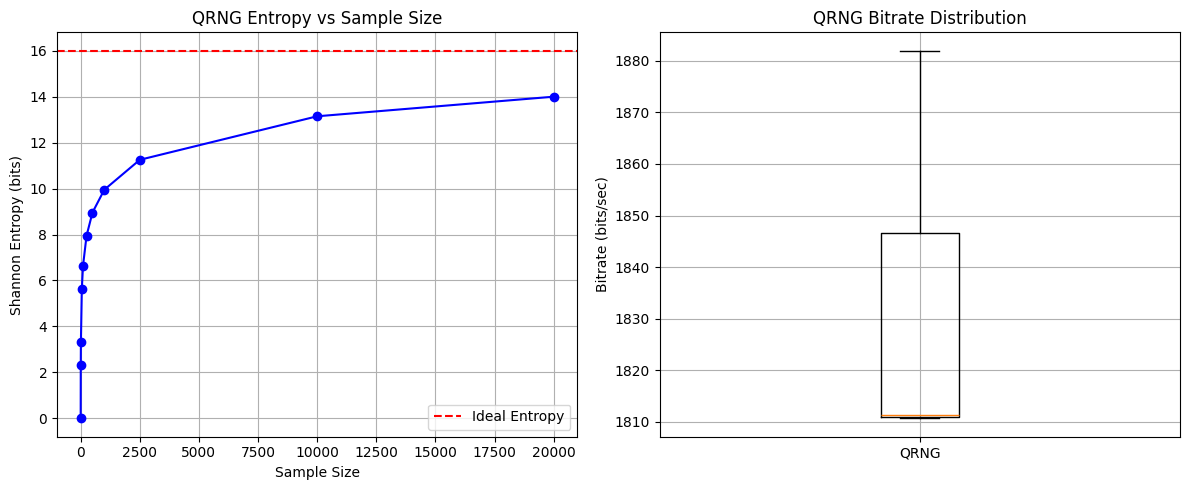


Entropy Summary:
Size      1: -0.00 bits (ideal: 16 bits)
Size      5: 2.32 bits (ideal: 16 bits)
Size     10: 3.32 bits (ideal: 16 bits)
Size     50: 5.64 bits (ideal: 16 bits)
Size    100: 6.64 bits (ideal: 16 bits)
Size    250: 7.95 bits (ideal: 16 bits)
Size    500: 8.96 bits (ideal: 16 bits)
Size   1000: 9.95 bits (ideal: 16 bits)
Size   2500: 11.25 bits (ideal: 16 bits)
Size  10000: 13.15 bits (ideal: 16 bits)
Size  20000: 14.00 bits (ideal: 16 bits)

Bitrate Summary:
Mean: 1834.62 bits/sec
Std Dev: 33.47 bits/sec
Min: 1810.68 bits/sec
Max: 1881.95 bits/sec


In [ ]:
# Visualization
plt.figure(figsize=(12, 5))

# Entropy Plot
plt.subplot(1, 2, 1)
plt.plot(SAMPLE_SIZES, entropy_values, marker='o', color='blue', linestyle='-')
plt.xlabel('Sample Size')
plt.ylabel('Shannon Entropy (bits)')
plt.title('QRNG Entropy vs Sample Size')
plt.axhline(y=BIT_LENGTH, color='red', linestyle='--', label='Ideal Entropy')
plt.legend()
plt.grid(True)

# Bitrate Plot
plt.subplot(1, 2, 2)
if bitrates:  # Only plot if we have successful trials
    plt.boxplot(bitrates, labels=['QRNG'])
    plt.ylabel('Bitrate (bits/sec)')
    plt.title('QRNG Bitrate Distribution')
else:
    plt.text(0.5, 0.5, 'No successful bitrate measurements', 
             ha='center', va='center')
    plt.title('Bitrate Measurement Failed')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nEntropy Summary:")
for size, entropy in zip(SAMPLE_SIZES, entropy_values):
    print(f"Size {size:6d}: {entropy:.2f} bits (ideal: {BIT_LENGTH} bits)")

if bitrates:
    print("\nBitrate Summary:")
    print(f"Mean: {np.mean(bitrates):.2f} bits/sec")
    print(f"Std Dev: {np.std(bitrates):.2f} bits/sec")
    print(f"Min: {np.min(bitrates):.2f} bits/sec")
    print(f"Max: {np.max(bitrates):.2f} bits/sec")
else:
    print("\nBitrate measurement failed in all trials")

### Part B: Easy as Pi!

In [11]:
def estimate_pi_qrng(num_points: int, qrng: QRNGaaS) -> float:
    circle_points = 0
    square_points = 0

    # Generate x and y coordinates in batches
    points_per_batch = 1000  # Adjust based on API limits and performance
    for i in range(0, num_points, points_per_batch):
        batch_size = min(points_per_batch, num_points - i)
        
        # Fetch random x and y coordinates in [-1, 1)
        rand_x = qrng.get_random_doubles_batched(batch_size, -1.0, 1.0)
        rand_y = qrng.get_random_doubles_batched(batch_size, -1.0, 1.0)

        if len(rand_x) != batch_size or len(rand_y) != batch_size:
            print(f"Warning: Insufficient random numbers received for batch {i}")
            continue

        # Process each point in the batch
        for x, y in zip(rand_x, rand_y):
            origin_dist = x**2 + y**2
            if origin_dist <= 1:
                circle_points += 1
            square_points += 1

    # Estimate Pi
    if square_points == 0:
        return 0.0
    pi_estimate = 4 * circle_points / square_points
    return pi_estimate

In [15]:
if __name__ == "__main__":
    INTERVAL = 50
    TOTAL_POINTS = INTERVAL ** 2 
    qrng = QRNGaaS(API_KEY)
    pi = estimate_pi_qrng(TOTAL_POINTS, qrng)
    print(f"Final Estimation of Pi (QRNG) = {pi}")

Final Estimation of Pi (QRNG) = 3.1456
